In [4]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow, imsave

In [5]:
img_path = 'data/image_1024_aligned_rgb.png'
plan_path = 'data/floor_plan_test.jpg'
partition_path = 'data/partition.jpg'
depth_path = 'data/depth_map.npy'

In [6]:
img = imread(img_path)
plan = imread(plan_path)
partition = imread(partition_path)
depth = np.load(depth_path)

In [7]:
img.shape

(512, 1024, 3)

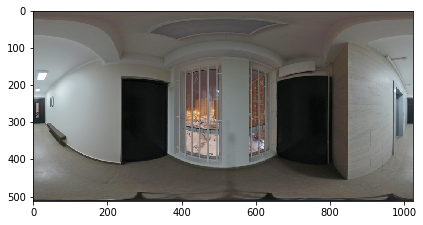

In [8]:
imshow(img)

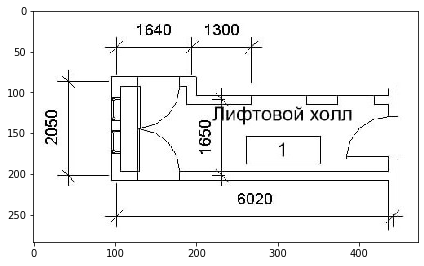

In [9]:
imshow(plan)

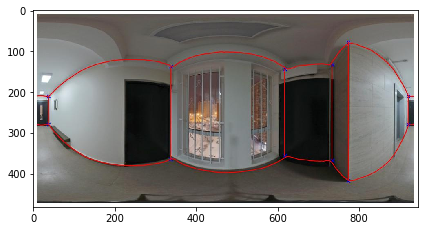

In [10]:
imshow(partition)

In [11]:
horizontal_corners = np.load('data/h_corners.npy')
vertical_corners = np.load('data/v_corners.npy')

In [12]:
print(horizontal_corners.shape)
print(vertical_corners.shape)

(2, 1024)
(12, 2)


In [13]:
from skimage.draw import disk, set_color

In [14]:
def plot_corner(img, corner, r):
    rr, cc = disk(corner, r, shape=img.shape)
    set_color(img, (rr, cc), (0, 0, 255))
    # img[rr, cc] = 1


In [15]:
def get_img_with_v_corners(img, v_corners, r = 10):
    img_with_corners = img.copy()
    for i in range(0, v_corners.shape[0], 2):
        lower = v_corners[i][::-1]
        higher = v_corners[i+1][::-1]
        plot_corner(img_with_corners, higher, r)
        plot_corner(img_with_corners, lower, r)
    return img_with_corners

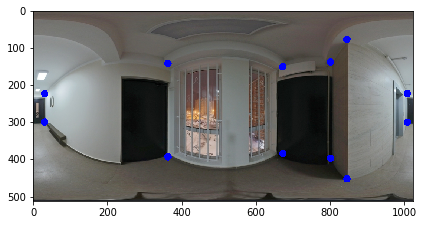

In [16]:
img_with_corn = get_img_with_v_corners(img, vertical_corners)
imshow(img_with_corn)

In [17]:
def plot_h_corners(img, h_corners, r = 2):
    # img_with_corners = img.copy()
    for x in range(h_corners.shape[1]):
        top_y = h_corners[0,x]
        bottom_y = h_corners[1, x]
        plot_corner(img, (top_y, x), r)
        plot_corner(img, (bottom_y, x), r)

In [18]:
img_with_h_corn = img_with_corn.copy()
plot_h_corners(img_with_h_corn, horizontal_corners, 2)

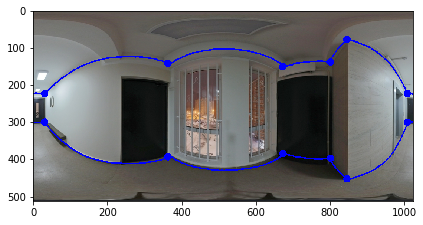

In [19]:
imshow(img_with_h_corn)

In [20]:
def get_point_status(p: tuple, h_corners: np.ndarray) -> str:
    '''
    Является точка частью потолка, стены или пола 
    '''
    y, x = p[0], p[1]

    top_h_corner = h_corners[0, x]
    bottom_h_corner = h_corners[1, x]

    if y <= top_h_corner:
        return 'ceiling'
    elif y >= bottom_h_corner:
        return 'floor'
    else:
        return 'wall'


In [21]:
def get_horizontal_masks(w: int, h: int, h_corners: np.ndarray) -> np.ndarray:
    ceiling_mask = np.zeros((h, w), dtype=bool)
    floor_mask = np.zeros((h, w), dtype=bool)
    wall_mask = np.zeros((h, w), dtype=bool)
    for x in range(h_corners.shape[1]):
        top_y = int(h_corners[0, x])
        ceiling_mask[:top_y, x] = True
    
        bottom_y = int(h_corners[1, x]) 
        floor_mask[bottom_y:, x] = True

        wall_mask[top_y:bottom_y, x] = True
    return ceiling_mask, wall_mask, floor_mask

def get_vertical_masks(w: int, h: int, vertical_corners: np.ndarray) -> np.ndarray:
    split_line_x = [0]
    for i in range(0, vertical_corners.shape[0], 2):
        split_line_x.append(vertical_corners[i, 0])
    
    split_line_x.append(w)
    split_line_x.sort()
    segments_number = len(split_line_x) - 1
    segments_masks = []

    for i in range(segments_number):
        mask = np.zeros((h, w), dtype=bool)
        left_x = int(split_line_x[i])
        right_x = int(split_line_x[i + 1])
        mask[:,left_x:right_x] = True
        segments_masks.append(mask)

    return segments_masks

In [22]:
ceil_mask, wall_mask, floor_mask = get_horizontal_masks(img.shape[1], img.shape[0], horizontal_corners)

In [23]:
print(ceil_mask[...,None].shape)
print(img.shape)

(512, 1024, 1)
(512, 1024, 3)


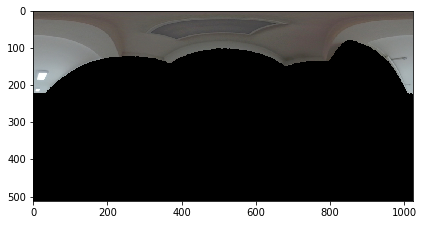

In [24]:
ceil_img = img*ceil_mask[...,None]
imshow(ceil_img)

In [25]:
segments_masks = get_vertical_masks(img.shape[1], img.shape[0], vertical_corners)

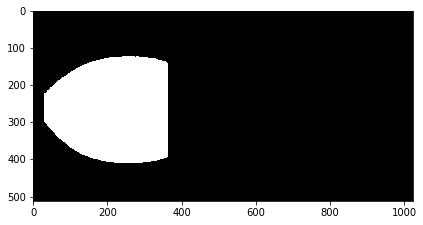

In [26]:
segment_0_mask = segments_masks[1]*wall_mask
imshow(segment_0_mask)

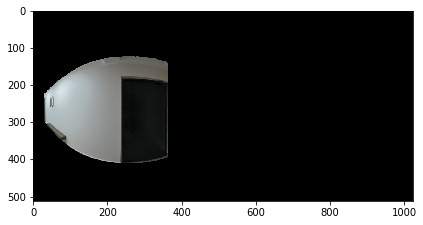

In [27]:
segment_0 = img*segment_0_mask[..., None]
imshow(segment_0)

In [28]:
def get_masked_segment(img: np.ndarray, segments_masks: list, segm_id: int):
    mask = segments_masks[segm_id]*wall_mask
    return img*mask[...,None], mask

c:\ProgramData\Python3_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


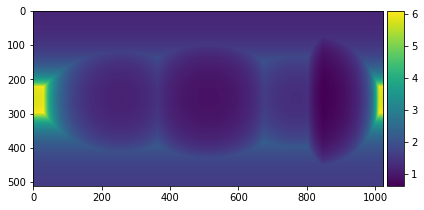

In [29]:
imshow(depth)

In [30]:
ceil_height = 2.5
pixel_scale = 2.5/512 # м/пиксель

In [31]:
def dot_product(v1: np.ndarray, v2: np.ndarray):
    return np.sum(v1*v2)  

In [107]:
class CoordinatesTransformer:
    ''' класс для преобразования из координат изображения в пространственные

        https://en.wikipedia.org/wiki/Equirectangular_projection

       '''

    def __init__(self, img: np.ndarray, depth_map: np.ndarray):
        
        self.img = img
        self.depth_map = depth_map
        

        self.img_h = img.shape[0]
        self.img_w = img.shape[1]

        self.cos_1 = 1

        self.phi_origin = 0
        self.thetta_origin = 0

    def from_img_to_spherical(self, i, j):
        thetta = (i - self.thetta_origin)/self.img_h*np.pi 
        
        phi = (j - self.phi_origin)/self.img_w*2*np.pi/self.cos_1 
        return self.depth_map[i,j], phi, thetta

    def from_spherical_to_img(self, phi, thetta):
        i = thetta*self.img_h/np.pi + self.thetta_origin
        j = phi*self.img_w/2/np.pi + self.phi_origin*self.cos_1
        return int(i), int(j)

    def get_global_point(self, p):
        r, phi, thetta = self.from_img_to_spherical(p[0], p[1])
        global_x = r*np.sin(thetta)*np.cos(phi)
        global_y = r*np.sin(thetta)*np.sin(phi)
        global_z = r*np.cos(thetta)
        return np.array([global_x, global_y, global_z])
    
    def get_img_point(self, global_p):
        x,y,z = global_p[0], global_p[1], global_p[2]
        r = np.sqrt(x**2 + y**2 + z**2)
        thetta = np.arccos(z/(r + 1e-12))
        phi = np.arctan(y/(x + 1e-12))
        i,j = self.from_spherical_to_img(phi, thetta)
        return i,j

    def test(self):
        for i in range(self.img_h):
            for j in range(self.img_w):
                ii, jj = self.get_img_point(self.get_global_point((i,j)))
                if np.abs(ii - i) >= 2 or np.abs(jj - j) >= 2:
                    print(i,j, ii, jj)

        

In [108]:
def normalize(v):
    return v/np.sqrt(np.sum(v**2))

In [109]:
class FlatBasisSystem:
    ''' класс отвечающий за систему координат плоскости. Строит плоскость по 3м точкам '''

    def __init__(self, c1, c2, c3):

        self.origin = c1

        # базисные вектора
        self.u = normalize(c2 - c1)
        self.v = normalize(c3 - c1)
        self.normal = np.cross(self.u, self.v)
        assert(np.abs((self.u*self.v).sum()) > 1e-7)

    def get_global_point(self, pu, pv):
        return self.origin + self.u*pu + self.v*pv
    
    def get_local_point(self, global_p):
        p = global_p - self.origin
        p = p - dot_product(p, self.normal)*self.normal
        pu = dot_product(p, self.u)
        pv = dot_product(p, self.v) 
        return pu, pv
    


In [110]:
def get_img_v_corner_i_j(vertical_corners, corn_id):
    return int(vertical_corners[corn_id, 1]), int(vertical_corners[corn_id, 0])

In [111]:
class FlatSegmentObject3D:
    ''' класс содержащий методы для работы с плоскостями в пространстве '''
    

    def __init__(self, img: np.ndarray, segment_mask: np.ndarray, basis: FlatBasisSystem, coord_transformer: CoordinatesTransformer):
        
        self.basis = basis
        self.img = img
        self.segment_mask = segment_mask
        self.coord_transformer = coord_transformer


    def get_local_size(self):
        ''' h = max(i), w = max(j)'''
        h = -1
        w = -1
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if not self.segment_mask[i,j]:
                    continue
                global_p = self.coord_transformer.get_global_point((i, j))
                pi,pj = self.basis.get_local_point(global_p)
                if pi > h:
                    h = pi
                if pj > w:
                    w = pj
        return w, h


In [112]:
def reconstruct(projection, img, mask, coord_transformer, basis, scale_i, scale_j):
    for i in range(projection.shape[0]):
        for j in range(projection.shape[1]):
            pu = scale_i*i
            pv = scale_j*j

            global_p = basis.get_global_point(pu, pv)

            img_i, img_j = coord_transformer.get_img_point(global_p)

            if img_i >= img.shape[0] or img_j >= img.shape[1]:
                continue

            if mask[img_i, img_j]:
                projection[i,j] = img[img_i, img_j]

In [113]:
def get_basis(c1_idx, c2_idx, c3_idx, coord_transformer):
    c1 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, c1_idx))
    c2 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, c2_idx))
    c3 = coord_transformer.get_global_point(get_img_v_corner_i_j(vertical_corners, c3_idx))

    basis = FlatBasisSystem(c1, c2, c3)
    return basis

In [114]:
def prepare_data_for_reconstruct(img, depth, c1_idx, c2_idx, c3_idx, hp, wp, mask, coord_transformer):
    # coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    
    # c2 - c1 -> u -> i -> h
    # c3 - c1 -> v -> j -> w
    basis = get_basis(c1_idx, c2_idx, c3_idx, coord_transformer)

    size_i_p = int(hp/pixel_scale)
    size_j_p = int(wp/pixel_scale)


    projection = np.zeros((size_i_p, size_j_p, 3), dtype = 'uint8')


    wall = FlatSegmentObject3D(img, mask, basis, coord_transformer)
    w, h = wall.get_local_size()

    return projection, basis, h/size_i_p, w/size_j_p

In [115]:
def get_projection(img, depth, c1_idx, c2_idx, c3_idx, hp, wp, mask, coord_transformer):
    projection, basis, scale_i, scale_j = prepare_data_for_reconstruct(img, depth, c1_idx, c2_idx, c3_idx, hp, wp, mask, coord_transformer)
    reconstruct(projection, img, mask, coord_transformer, basis, scale_i, scale_j)
    return projection

In [116]:
def reconstruct_wall_0(coord_transformer):
    return get_projection(img, depth, 0, 1, 2, 2.5, 6.02, get_masked_segment(img, segments_masks, 1)[1], coord_transformer)

In [117]:
def reconstruct_floor(coord_transformer):
    return get_projection(img, depth, 3, 5, 1, 2.05, 6.02, floor_mask, coord_transformer)

In [118]:
def reconstruct_ceiling(coord_transformer):
    return get_projection(img, depth, 2, 4, 0, 2.05, 6.02, ceil_mask, coord_transformer)

In [119]:
def reconstruct_wall_1(coord_transformer = None):
    if coord_transformer is None:
        coord_transformer = CoordinatesTransformer(img, depth)
        coord_transformer.phi_origin = 600
        coord_transformer.thetta_origin = 0
        coord_transformer.cos_1 = 1
    return get_projection(img, depth, 2, 3, 4, 2.5, 2.05, get_masked_segment(img, segments_masks, 2)[1], coord_transformer)

In [120]:
def reconstruct_wall_2(coord_transformer = None):
    if coord_transformer is None:
        coord_transformer = CoordinatesTransformer(img, depth)
        coord_transformer.phi_origin = 595
        coord_transformer.thetta_origin = 0
        coord_transformer.cos_1 = 1
        
    return get_projection(img, depth, 4, 5, 6, 2.5, 1.6, get_masked_segment(img, segments_masks, 3)[1], coord_transformer)

In [121]:
def reconstruct_wall_3(coord_transformer):
    return get_projection(img, depth, 5, 6, 7, 2.5, 0.4, get_masked_segment(img, segments_masks, 4)[1], coord_transformer)

In [122]:
def reconstruct_wall_4(coord_transformer = None):
    if coord_transformer is None:
        coord_transformer = CoordinatesTransformer(img, depth)
        coord_transformer.phi_origin = 0
        coord_transformer.thetta_origin = 0
        coord_transformer.cos_1 = 0.503
    return get_projection(img, depth, 6, 7, 8, 2.5, 4.38, get_masked_segment(img, segments_masks, 5)[1], coord_transformer)

In [123]:
def show_projections(projections):
    plt.figure(figsize=(20,10))
    columns = 4
    # projections = [floor_proj, ceil_proj, wall_0_proj, wall_1_proj, wall_2_proj, wall_3_proj, wall_4_proj]
    for i, image in enumerate(projections):
        plt.subplot(int(len(projections) / columns) + 1, columns, i + 1)
        plt.imshow(image)

In [124]:
def get_all_projections():
    projections = []

    default_transformer = CoordinatesTransformer(img, depth)
    projections.append(reconstruct_floor(default_transformer))
    projections.append(reconstruct_ceiling(default_transformer))
    projections.append(reconstruct_wall_0(default_transformer))
    projections.append(reconstruct_wall_1())


    projections.append(reconstruct_wall_2())
    projections.append(reconstruct_wall_3(default_transformer))
    projections.append(reconstruct_wall_4())
    return projections

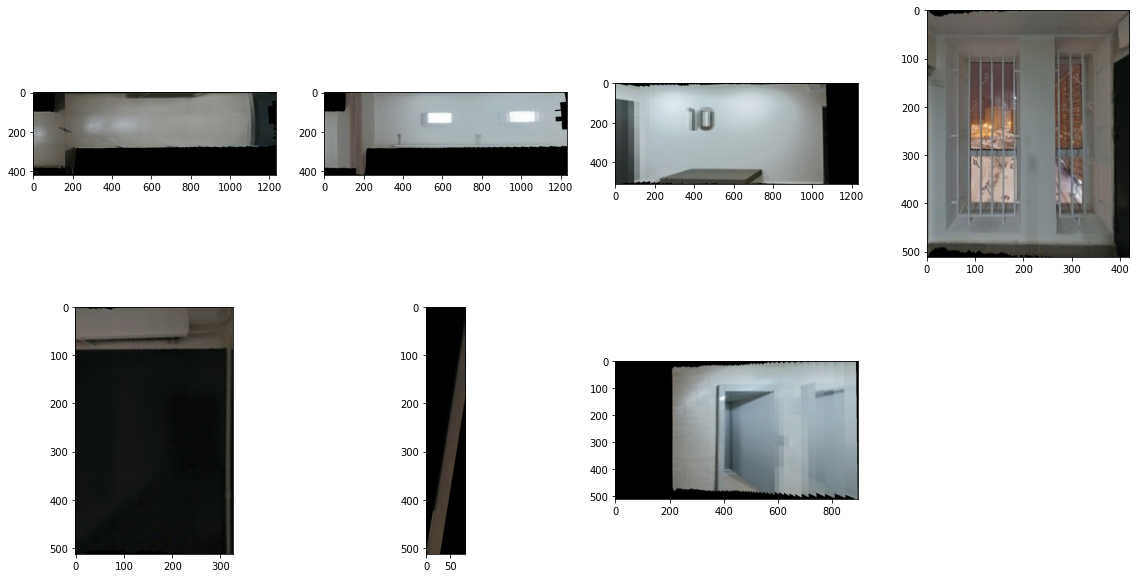

In [125]:
show_projections(get_all_projections())

In [126]:
from tqdm import tqdm

In [61]:
def explore():
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    result = []
    for phi_origin in tqdm(range(0, img.shape[1], 30)):
        for thetta_origin in range(0, img.shape[0], 15):
            coord_transformer.phi_origin = phi_origin
            coord_transformer.thetta_origin = thetta_origin

            projections = get_all_projections(coord_transformer)
            result.append(projections)
    return result

In [67]:
import ipywidgets as widgets

In [82]:
@widgets.interact(i = (0, 1024), j = (0, 512), k = (0, 1000))
def find_angle(i: int, j: int, k: int):
    coord_transformer = CoordinatesTransformer(img, depth, ceil_height)
    coord_transformer.phi_origin = i
    coord_transformer.thetta_origin = j
    coord_transformer.cos_1 = k/1000
    proj = reconstruct_wall_4(coord_transformer)
    print('done', i, j)
    imshow(proj)
    # imsave("3_proj.jpg", proj)

interactive(children=(IntSlider(value=512, description='i', max=1024), IntSlider(value=256, description='j', m…